In [1]:
import networkx as nx
import numpy as np
import functools
import random


In [2]:
from optiLib.problem import NetGraph
from optiLib.problem import TaskGraph

def generate_adjacency_matrix(rows, cols):
    num_nodes = rows * cols
    adjacency_matrix = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]

    for row in range(rows):
        for col in range(cols):
            node_index = row * cols + col
            if col > 0:  # узел слева
                adjacency_matrix[node_index][node_index - 1] = 1
            if col < cols - 1:  # узел справа
                adjacency_matrix[node_index][node_index + 1] = 1
            if row > 0:  # узел сверху
                adjacency_matrix[node_index][node_index - cols] = 1
            if row < rows - 1:  # узел снизу
                adjacency_matrix[node_index][node_index + cols] = 1

    return adjacency_matrix


martx = [
    [0, 2000, 2000, 2000, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 500, 1000, 0, 0, 0, 0], 
    [0, 0, 0, 0, 0, 500, 0, 0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 1000, 0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 500, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 300, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 300, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 200], 
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 200], 
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
]
task = TaskGraph(martx, w_arr=[500, 1000, 5000, 2000, 200, 300, 1000, 500, 500, 150])

martx = [
[0, 500, 1000, 500, 1000, 0, 0], 
[500, 0, 0, 0, 0, 1000, 0], 
[1000, 0, 0, 2000, 0, 2000, 0], 
[500, 0, 2000, 0, 0, 0, 500], 
[1000, 0, 0, 0, 0, 0, 0], 
[0, 1000, 2000, 0, 0, 0, 500], 
[0, 0, 0, 500, 0, 500, 0, ]
]
net  = NetGraph(martx, net_power=(1000, 2500), net_power_arr=[2000, 500, 1500, 1000, 500, 2500, 500], e0=(10, 50), emax=(70,100))


In [3]:
import functools
import networkx as nx
import numpy as np

@functools.lru_cache
def create_paths(vector, task_edges, network_graph):
    RANDOM_SEED = 1
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    paths = {}
    
    for start, end in task_edges:
        if vector[start] == vector[end]:
            paths[str(start) + str(end)] = [vector[start]]
        else:
            paths[str(start) + str(end)] = random.choice(list(nx.all_shortest_paths(network_graph, vector[start], vector[end])))
    return paths

@functools.lru_cache
def network_status_calculation(vector, problem):
    RANDOM_SEED = 1
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    
    T_lim = problem.t_lim
    vector_tuple = tuple(vector) 
    task_edges = tuple((start, end) for start, end, _ in nx.to_edgelist(problem.task_graph.graph))
    network_graph = problem.network_graph.graph
    
    paths = create_paths(vector_tuple, task_edges, network_graph)
    
    net_number = network_graph.number_of_nodes()
    task_number = problem.task_graph.graph.number_of_nodes()

    W = [0] * net_number
    v_task_to_node = [0] * net_number
    v_sent_to_node = [0] * net_number
    v_reseive_to_node = [0] * net_number
    
    for start, end, weight in nx.to_edgelist(problem.task_graph.graph):
        path_key = str(start) + str(end)
        path = paths[path_key]
        
        if len(path) > 1:
            W[path[0]] += problem.task_graph.operations[start].w + weight['weight']
            v_sent_to_node[path[0]] += weight['weight']
            v_task_to_node[path[0]] += problem.task_graph.operations[start].w
            
            W[path[-1]] += problem.task_graph.operations[end].w + weight['weight']
            v_reseive_to_node[path[-1]] += weight['weight']
            v_task_to_node[path[-1]] += problem.task_graph.operations[end].w
            
            for node in path[1:-1]:
                W[node] += 2 * weight['weight']
                v_sent_to_node[node] += weight['weight']
                v_reseive_to_node[node] += weight['weight']
        else:
            W[vector[start]] += problem.task_graph.operations[start].w
            v_task_to_node[vector[start]] += problem.task_graph.operations[start].w
            
            W[vector[end]] += problem.task_graph.operations[end].w
            v_task_to_node[vector[end]] += problem.task_graph.operations[end].w
    
    vector_tuple = tuple(vector) 
    
    arr = sorted(nx.all_simple_paths(problem.task_graph.graph, 0, task_number - 1), key=len, reverse=True)
    
    T_task = [0] * task_number
    len_first_path = len(arr[0])
    time_per_task = T_lim / len_first_path
    
    for task in arr[0]:
        T_task[task] = time_per_task
    
    for path_task in arr[1:]:
        sum_t = sum(T_task[task] for task in path_task)
        temp = [task for task in path_task if T_task[task] == 0]
        
        if temp:  # если нашлись задачи без оценки времени
            time_remaining = max(0, T_lim - sum_t)
            time_per_task_temp = time_remaining / len(temp)
            for task in temp:
                T_task[task] = time_per_task_temp
    
    T_NET = [0] * net_number

    for start, end, _ in nx.to_edgelist(problem.task_graph.graph):
        path_net = paths[str(start) + str(end)]
        if len(path_net) == 1:
            T_NET[path_net[-1]] = min(T_NET[path_net[-1]] or time_per_task, T_task[start], T_task[end])
        else:
            T_NET[path_net[-1]] = min(T_NET[path_net[-1]] or T_task[end], T_task[end])
            time_start_share = T_task[start] / (len(path_net) - 1)
            for node in path_net[:-1]:
                T_NET[node] = min(T_NET[node] or time_start_share, time_start_share)
    
    special_t = T_lim / len_first_path
    result = [[] for _ in range(net_number)]
    for i, val in enumerate(vector):
        result[val].append(i)
    
    for node in range(net_number):
        common_tasks = set(result[node]) & set(arr[0])
        if len(common_tasks) > 1:
            T_NET[node] = special_t * len(common_tasks)
    
    D = [W[i] / (problem.network_graph.nodes[i].p * T_NET[i]) if T_NET[i] != 0 else 0 for i in range(net_number)]
    return {"w":W, "v_task_to_node":v_task_to_node, "v_sent_to_node":v_sent_to_node, "v_reseive_to_node":v_reseive_to_node, "D":D, "T_NET":T_NET, "T_task":T_task}

@functools.lru_cache
def status(vector, problem):
    problem.scheduler.calculate_schedule(vector)
    return {"Time":problem.scheduler.get_total_execution_time(), "edge_hop":problem.scheduler.get_transfer_count(), "time_node":problem.scheduler.get_node_working_times()}

def c1_time_limit(vector, problem):
    """
    Проверка на ограничение по времени
    """
    net_ststus = status(tuple(vector), problem)
    time = net_ststus['Time']
    return int(time <= problem.t_lim)

def c2_restriction_first_node(vector, problem):
    """
    Проверка на ограничение на первый узел 
    """
    net_ststus = status(tuple(vector), problem)
    time_node = net_ststus['time_node']
    return int(time_node[0] <= 1)


def min_hop(vector, problem):
    net_ststus = status(tuple(vector), problem)
    edge_hop = net_ststus['edge_hop']
    return edge_hop


def f1_min_hop(vector, problem):
    net_ststus = status(tuple(vector), problem)
    edge_hop = net_ststus['edge_hop']
    return edge_hop

def f_min_workload_node_0(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]

    node = 0
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload  


def f_min_workload_node_1(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 1
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_2(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 2
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_3(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 3
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_4(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 4
    workload = time_node.get(node, 0) / t 
    return 1 if workload == 0 else workload 

def f_min_workload_node_5(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 5
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_6(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 6
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_7(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 7
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_8(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 8
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f2(vector, problem):
    """
    Вычисляет количество пересылок данных, необходимых при распределении задач
    по узлам сети, если изначально все задачи были на узле 0.
    
    Args:
        vector (list): Вектор распределения задач на узлы сети.
        problem (): network_graph (nx.Graph): Граф сети.
        
    Returns:
        int: Общее количество пересылок данных.
    """
    total_transfers = 0
    network_graph = problem.network_graph.graph

    for task_id, node_id in enumerate(vector):
        if node_id != 0:
            # Найти кратчайший путь от узла 0 до текущего узла
            path = nx.shortest_path(network_graph, source=0, target=node_id)
            
            # Увеличить счетчик пересылок на количество узлов в пути
            total_transfers += len(path) - 1
    
    return total_transfers + 1


In [4]:
class NetworkObjectives:
    """
    Класс, содержащий целевые функции для оптимизации распределения задач в сети
    """
    
    @staticmethod
    def get_status(vector, problem):
        """
        Получает статус сети для вектора распределения
        
        Args:
            vector: Вектор распределения задач
            problem: Задача оптимизации
            
        Returns:
            dict: Словарь с метриками состояния сети
        """
        problem.scheduler.calculate_schedule(vector)
        return problem.scheduler.get_timing_statistics()

    @staticmethod
    def check_first_node_restriction(vector, problem):
        """
        Проверяет ограничение на загрузку первого узла
        """
        net_status = NetworkObjectives.get_status(vector, problem)
        return int(net_status['time_node'][0] <= 1)

    @staticmethod
    def minimize_hops(vector, problem):
        """
        Минимизирует количество переходов между узлами
        """
        net_status = NetworkObjectives.get_status(vector, problem)
        return net_status['edge_hop']

    @classmethod
    def get_node_workload(cls, vector, problem, node):
        """
        Вычисляет относительную загрузку узла
        
        Args:
            vector: Вектор распределения задач
            problem: Задача оптимизации
            node: Номер узла
            
        Returns:
            float: Относительная загрузка узла
        """
        net_status = cls.get_status(vector, problem)
        total_time = net_status["total_time"]
        workload = net_status["working_times"].get(node, 0) / total_time
        return None if workload == 0 else workload

    @classmethod
    def create_node_workload_objective(cls, node):
        """
        Создает функцию для минимизации загрузки конкретного узла
        
        Args:
            node: Номер узла
            
        Returns:
            function: Функция целевой оптимизации для узла
        """
        def node_workload(vector, problem):
            return cls.get_node_workload(vector, problem, node)
        
        node_workload.__name__ = f'f_min_workload_node_{node}'
        return node_workload

    @staticmethod
    def calculate_data_transfers(vector, problem):
        """
        Вычисляет количество необходимых пересылок данных
        
        Args:
            vector: Вектор распределения задач
            problem: Задача оптимизации
            
        Returns:
            int: Общее количество пересылок данных
        """
        stats = NetworkObjectives.get_status(vector, problem)
        return stats['transfer_count']
    
    @staticmethod
    def load_balancing(vector, problem):
        """
        Балансировка нагрузки между узлами сети.
        
        Args:
            vector: Вектор распределения задач
            problem: Задача оптимизации
            
        Returns:
            int: Общее количество пересылок данных

        CV < 10% - очень однородные данные
        10% ≤ CV < 20% - однородные данные
        20% ≤ CV < 30% - средне однородные данные
        CV ≥ 30% - неоднородные данные
        """

        stats = NetworkObjectives.get_status(vector, problem)
        total_time = stats["total_time"]
        workload = np.divide(list(stats["working_times"].values()), total_time)

        if len(workload) == 0 or np.mean(workload) == 0:
            return np.inf
            
        return (np.std(workload) / np.mean(workload)) * 100

# Создание объектов целевых функций для узлов
node_objectives = {
    f'f_min_workload_node_{i}': NetworkObjectives.create_node_workload_objective(i)
    for i in range(7)  # создаем для узлов 0-8
}

# Определение основных целевых функций
optimization_objectives = {
    # 'c1_time_limit': NetworkObjectives.check_time_limit,
    # 'c2_restriction_first_node': NetworkObjectives.check_first_node_restriction,
    # 'min_hop': NetworkObjectives.minimize_hops,
    'f_load_balancing': NetworkObjectives.load_balancing,
    'f_data_transfers': NetworkObjectives.calculate_data_transfers,
    **node_objectives  # добавляем все целевые функции для узлов
}

In [5]:
class NetworkConstraints:
    """
    Класс, определяющий ограничения для задачи оптимизации сети
    """
    
    def __init__(self, max_hops=10, max_workload=0.8):
        """
        Инициализация ограничений
        
        Args:
            t_lim (float): Максимальное время выполнения
            max_hops (int): Максимальное количество переходов
            max_workload (float): Максимальная загрузка узла
        """
        self.max_hops = max_hops
        self.max_workload = max_workload

    def get_basic_constraints(self):
        """
        Получение базовых ограничений на функции
        """
        return {
            NetworkObjectives.check_time_limit: [1, 1],  # Должно быть точно равно 1
            NetworkObjectives.minimize_hops: [0, self.max_hops],  # Не более max_hops переходов
            NetworkObjectives.calculate_data_transfers: [0, float('inf')]  # Без верхней границы
        }

    @staticmethod
    def check_time_limit(vector, problem):
        """
        Проверяет ограничение по времени выполнения
        """
        net_status = NetworkObjectives.get_status(vector, problem)
        return int(net_status['total_time'] <= problem.t_lim)
    
    def get_node_workload_constraints(self, num_nodes):
        """
        Получение ограничений на загрузку узлов
        
        Args:
            num_nodes (int): Количество узлов в сети
        """
        return {
            NetworkObjectives.create_node_workload_objective(i): [0, self.max_workload]
            for i in range(num_nodes)
        }

    def get_special_constraints(self):
        """
        Получение специальных ограничений для групп узлов
        """
        return {
            # Ограничение для первых двух узлов
            (0, 1): {
                NetworkObjectives.get_node_workload: [0, 0.5]  # Максимум 50% загрузки
            },
            # Ограничение для узлов 2-4
            (2, 3, 4): {
                NetworkObjectives.get_node_workload: [0, 0.7]  # От 0% до 70% загрузки
            }
        }
    
constraints = NetworkConstraints(max_hops=8, max_workload=0.75)

In [6]:
from optiLib import NetworkOptimizationProblem

problem = NetworkOptimizationProblem(
    net, 
    task, 
    f_objective = optimization_objectives, 
    constraints = [constraints.check_time_limit],
    t_lim=20, 
    net_speed=100, 
    bounds={0: [0,0]}, 
    name="NETproblem_1", 
    node_functions=node_objectives,
    function_constraints = None,
    special_function_constraints= constraints.get_special_constraints()
)

In [7]:
from optiLib.problem import TaskScheduler
res = TaskScheduler(task, net)

In [8]:
problem.generate_random_solution()

array([0, 1, 5, 3, 0, 3, 1, 5, 4, 2])


Node Power:
Node 0: power 2000
Node 1: power 500
Node 2: power 1500
Node 3: power 1000
Node 4: power 500
Node 5: power 2500
Node 6: power 500

Task Workload:
Task 0: workload 500
Task 1: workload 1000
Task 2: workload 5000
Task 3: workload 2000
Task 4: workload 200
Task 5: workload 300
Task 6: workload 1000
Task 7: workload 500
Task 8: workload 500
Task 9: workload 150

Task Assignment to Nodes:
Task 0 assigned to node 4
Task 1 assigned to node 4
Task 2 assigned to node 4
Task 3 assigned to node 4
Task 4 assigned to node 4
Task 5 assigned to node 4
Task 6 assigned to node 4
Task 7 assigned to node 4
Task 8 assigned to node 4
Task 9 assigned to node 4

Data Transfers:


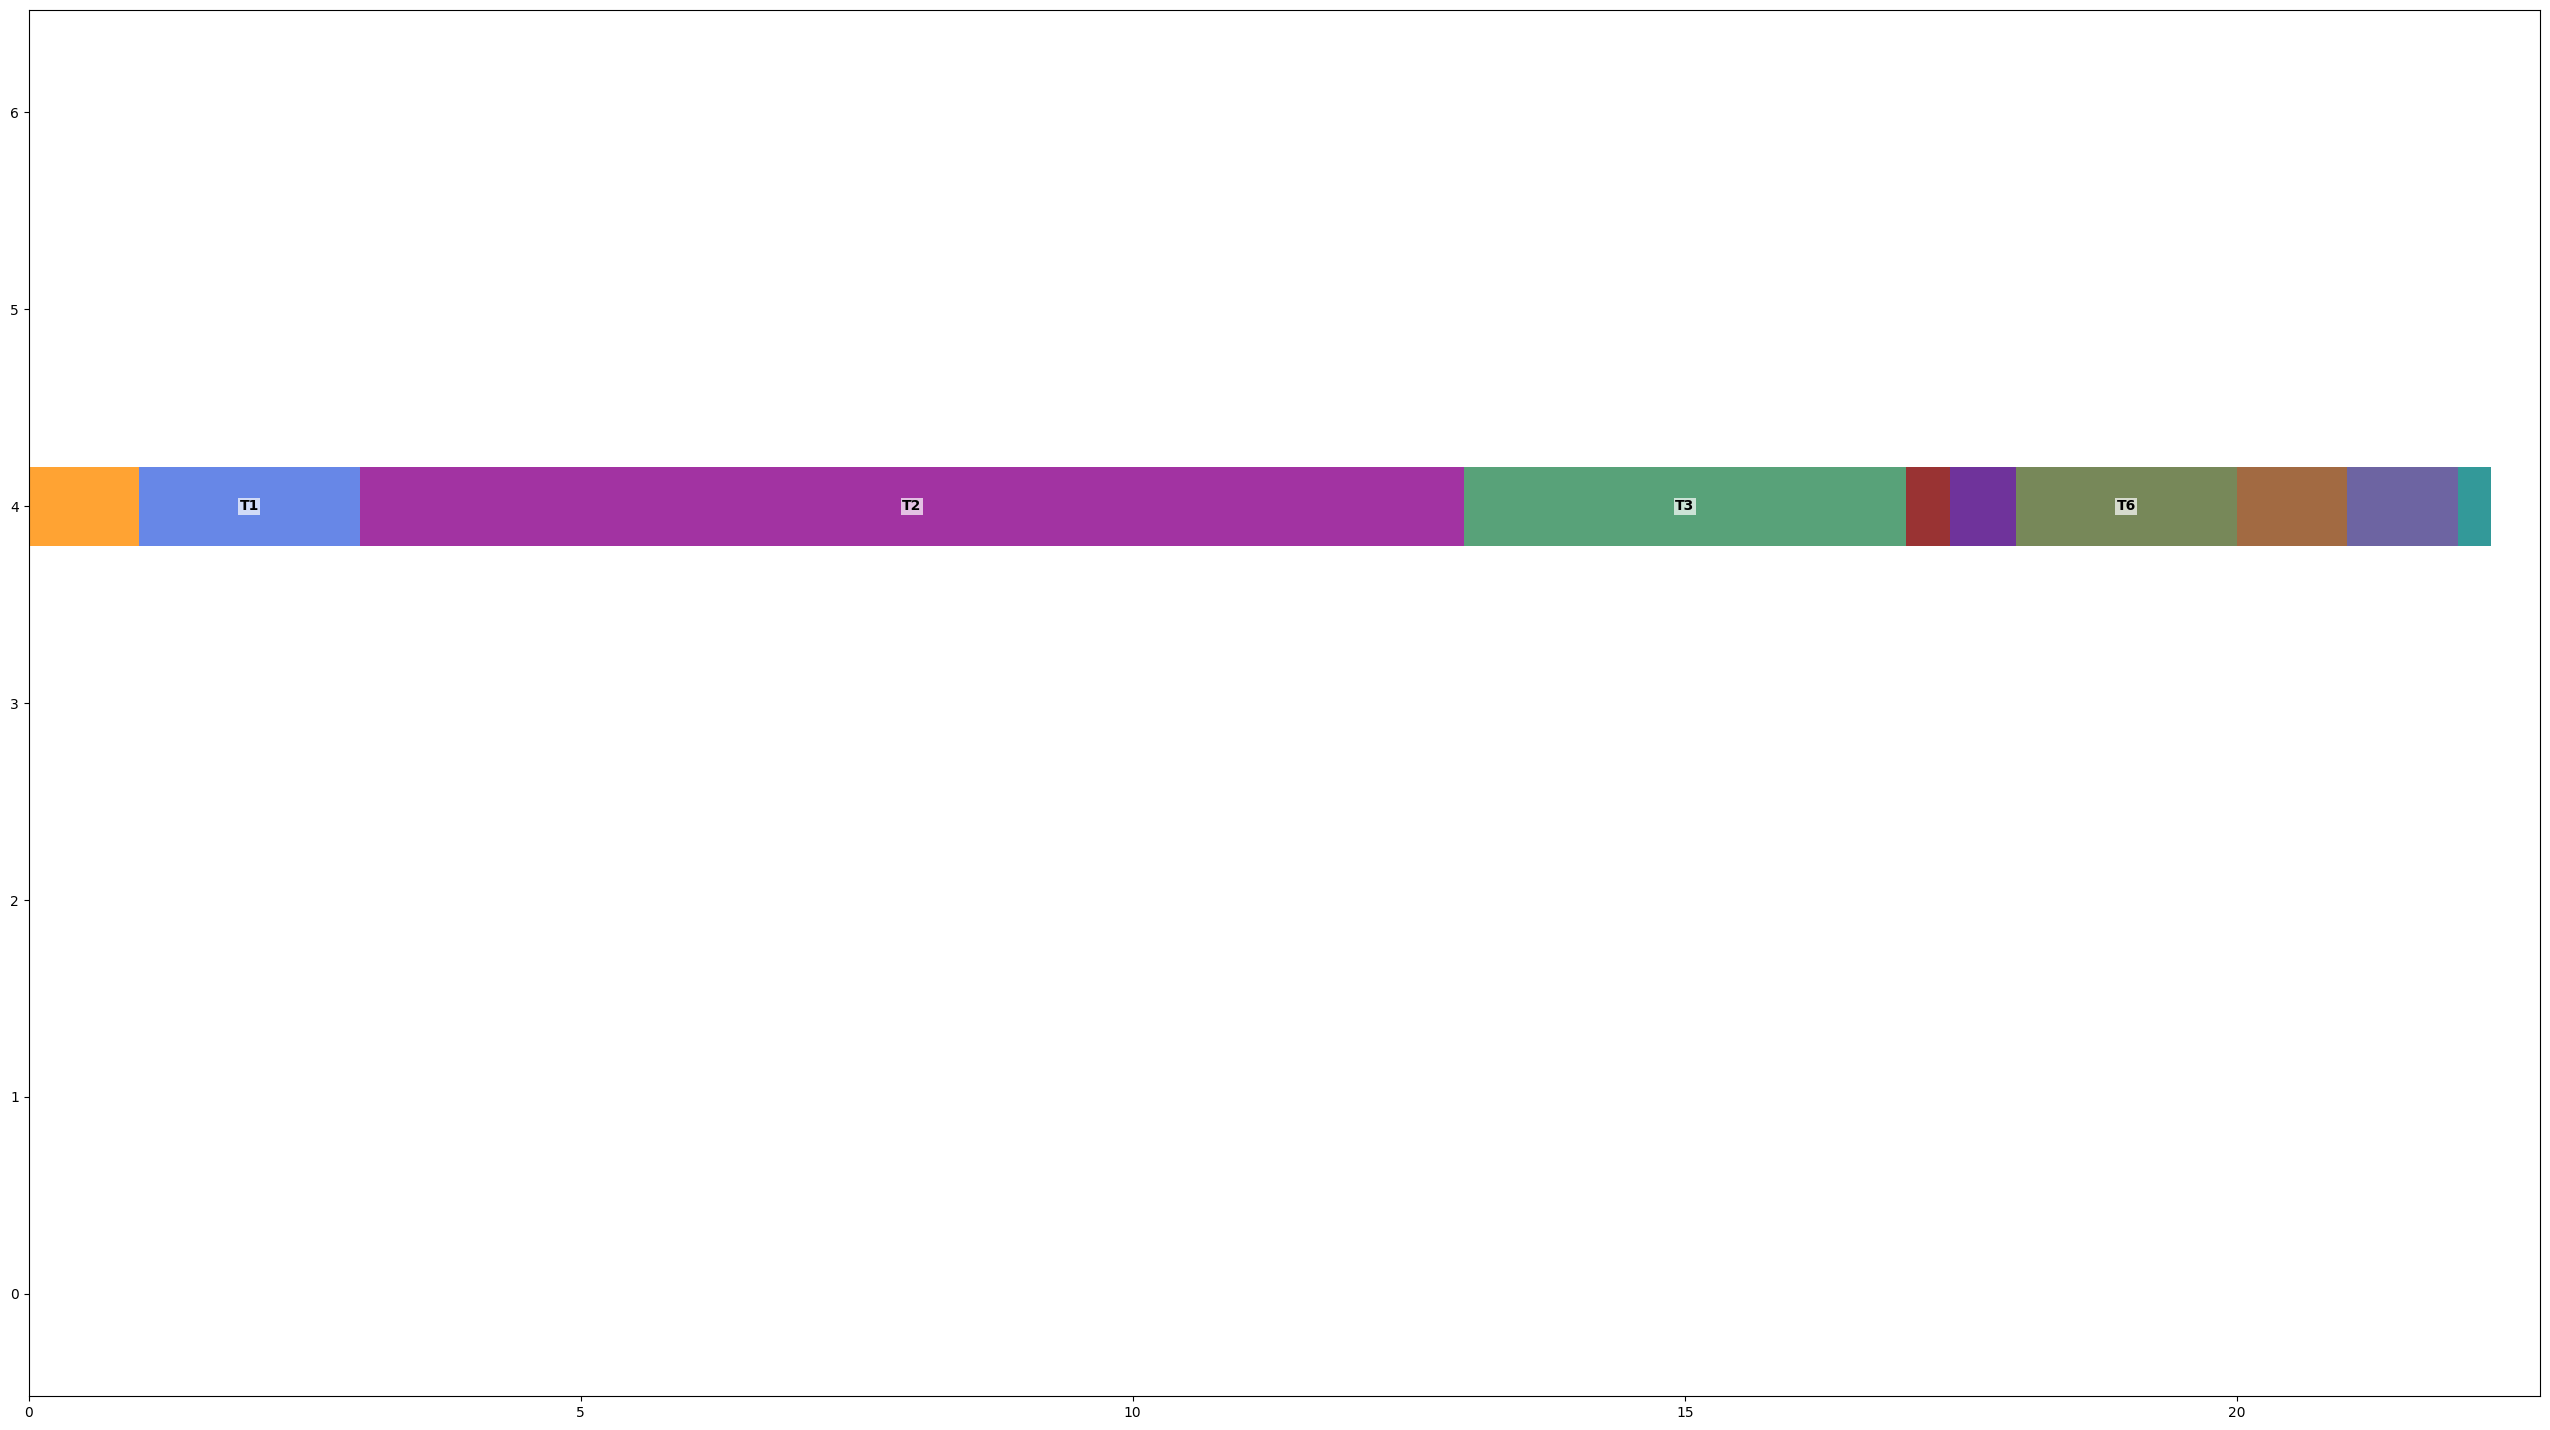

In [9]:
res.calculate_schedule([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
res.print_info()
res.create_gantt_chart()

In [10]:
def print_network_status(scheduler: TaskScheduler):
    """
    Выводит подробную информацию о состоянии сети в красивом форматировании.
    
    Параметры:
    ----------
    scheduler : TaskScheduler
        Планировщик задач с информацией о сети
    """
    
    # Цвета для форматирования
    HEADER = '\033[95m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    
    def print_separator(char="=", length=50):
        print(BLUE + char * length + ENDC)
        
    def print_section_header(text):
        print(HEADER + BOLD + f"\n{text:^50}" + ENDC)
        print_separator()
    
    # Получаем статистику
    stats = scheduler.get_timing_statistics()
    
    # Заголовок
    print_section_header("СОСТОЯНИЕ СЕТИ")
    
    # Информация о узлах
    print_section_header("ХАРАКТЕРИСТИКИ УЗЛОВ")
    for i, node in enumerate(scheduler.net_graph.nodes):
        print(f"{GREEN}Узел {i}:{ENDC}")
        print(f"├─ Вычислительная мощность: {BOLD}{node.p:.2f}{ENDC}")
        print(f"├─ Время работы: {BOLD}{stats['working_times'].get(i, 0):.2f}{ENDC}")
        print(f"├─ Время отправки данных: {BOLD}{stats['send_times'].get(i, 0):.2f}{ENDC}")
        print(f"└─ Время приема данных: {BOLD}{stats['receive_times'].get(i, 0):.2f}{ENDC}")
    
    # Информация о задачах
    print_section_header("РАСПРЕДЕЛЕНИЕ ЗАДАЧ")
    current_node = None
    for task, node in sorted(scheduler.node_assignments.items(), key=lambda x: x[1]):
        if current_node != node:
            if current_node is not None:
                print(f"└{'─' * 30}")
            current_node = node
            print(f"\n{GREEN}Узел {node}:{ENDC}")
        workload = scheduler.task_graph.operations[task].w
        print(f"├─ Задача {task} (сложность: {workload})")
    
    # Информация о передачах данных
    print_section_header("ПЕРЕДАЧИ ДАННЫХ")
    if scheduler.data_transfers:
        for src, dst, start, end, task, successor in scheduler.data_transfers:
            duration = end - start
            print(f"{BLUE}Передача T{task}→T{successor}:{ENDC}")
            print(f"├─ Маршрут: Узел {src} → Узел {dst}")
            print(f"├─ Время начала: {start:.2f}")
            print(f"├─ Время окончания: {end:.2f}")
            print(f"└─ Длительность: {duration:.2f}")
    else:
        print(f"{WARNING}Нет передач данных между узлами{ENDC}")
    
    # Общая статистика
    print_section_header("ОБЩАЯ СТАТИСТИКА")
    print(f"Общее время выполнения: {BOLD}{stats['total_time']:.2f}{ENDC}")
    print(f"Количество передач: {BOLD}{stats['transfer_count']}{ENDC}")
    
    # Загрузка узлов
    print_section_header("ЗАГРУЗКА УЗЛОВ")
    for node in range(len(scheduler.net_graph.nodes)):
        total_time = stats['total_time']
        working_time = stats['working_times'].get(node, 0)
        utilization = (working_time / total_time) * 100 if total_time > 0 else 0
        
        # Создаем визуальную шкалу загрузки
        bar_length = 20
        filled_length = int(utilization / 100 * bar_length)
        bar = '█' * filled_length + '░' * (bar_length - filled_length)
        
        # Выбираем цвет в зависимости от загрузки
        if utilization < 30:
            color = FAIL
        elif utilization < 70:
            color = WARNING
        else:
            color = GREEN
            
        print(f"Узел {node}: {color}{bar}{ENDC} {utilization:.1f}%")
    
    print_separator("=", 50)




                  СОСТОЯНИЕ СЕТИ                  

               ХАРАКТЕРИСТИКИ УЗЛОВ               
Узел 0:
├─ Вычислительная мощность: 2000.0000
├─ Время работы: 3.9750
├─ Время отправки данных: 2.2500
└─ Время приема данных: 0.5000
Узел 1:
├─ Вычислительная мощность: 500.0000
├─ Время работы: 1.2000
├─ Время отправки данных: 0.6000
└─ Время приема данных: 0.6000
Узел 2:
├─ Вычислительная мощность: 1500.0000
├─ Время работы: 0.0000
├─ Время отправки данных: 0.0000
└─ Время приема данных: 0.0000
Узел 3:
├─ Вычислительная мощность: 1000.0000
├─ Время работы: 10.6000
├─ Время отправки данных: 5.2000
└─ Время приема данных: 5.2000
Узел 4:
├─ Вычислительная мощность: 500.0000
├─ Время работы: 0.0000
├─ Время отправки данных: 0.0000
└─ Время приема данных: 0.0000
Узел 5:
├─ Вычислительная мощность: 2500.0000
├─ Время работы: 0.9200
├─ Время отправки данных: 0.1200
└─ Время приема данных: 0.4000
Узел 6:
├─ Вычислительная мощность: 500.0000
├─ Время работы: 27.4000
├─ Время отправки данны

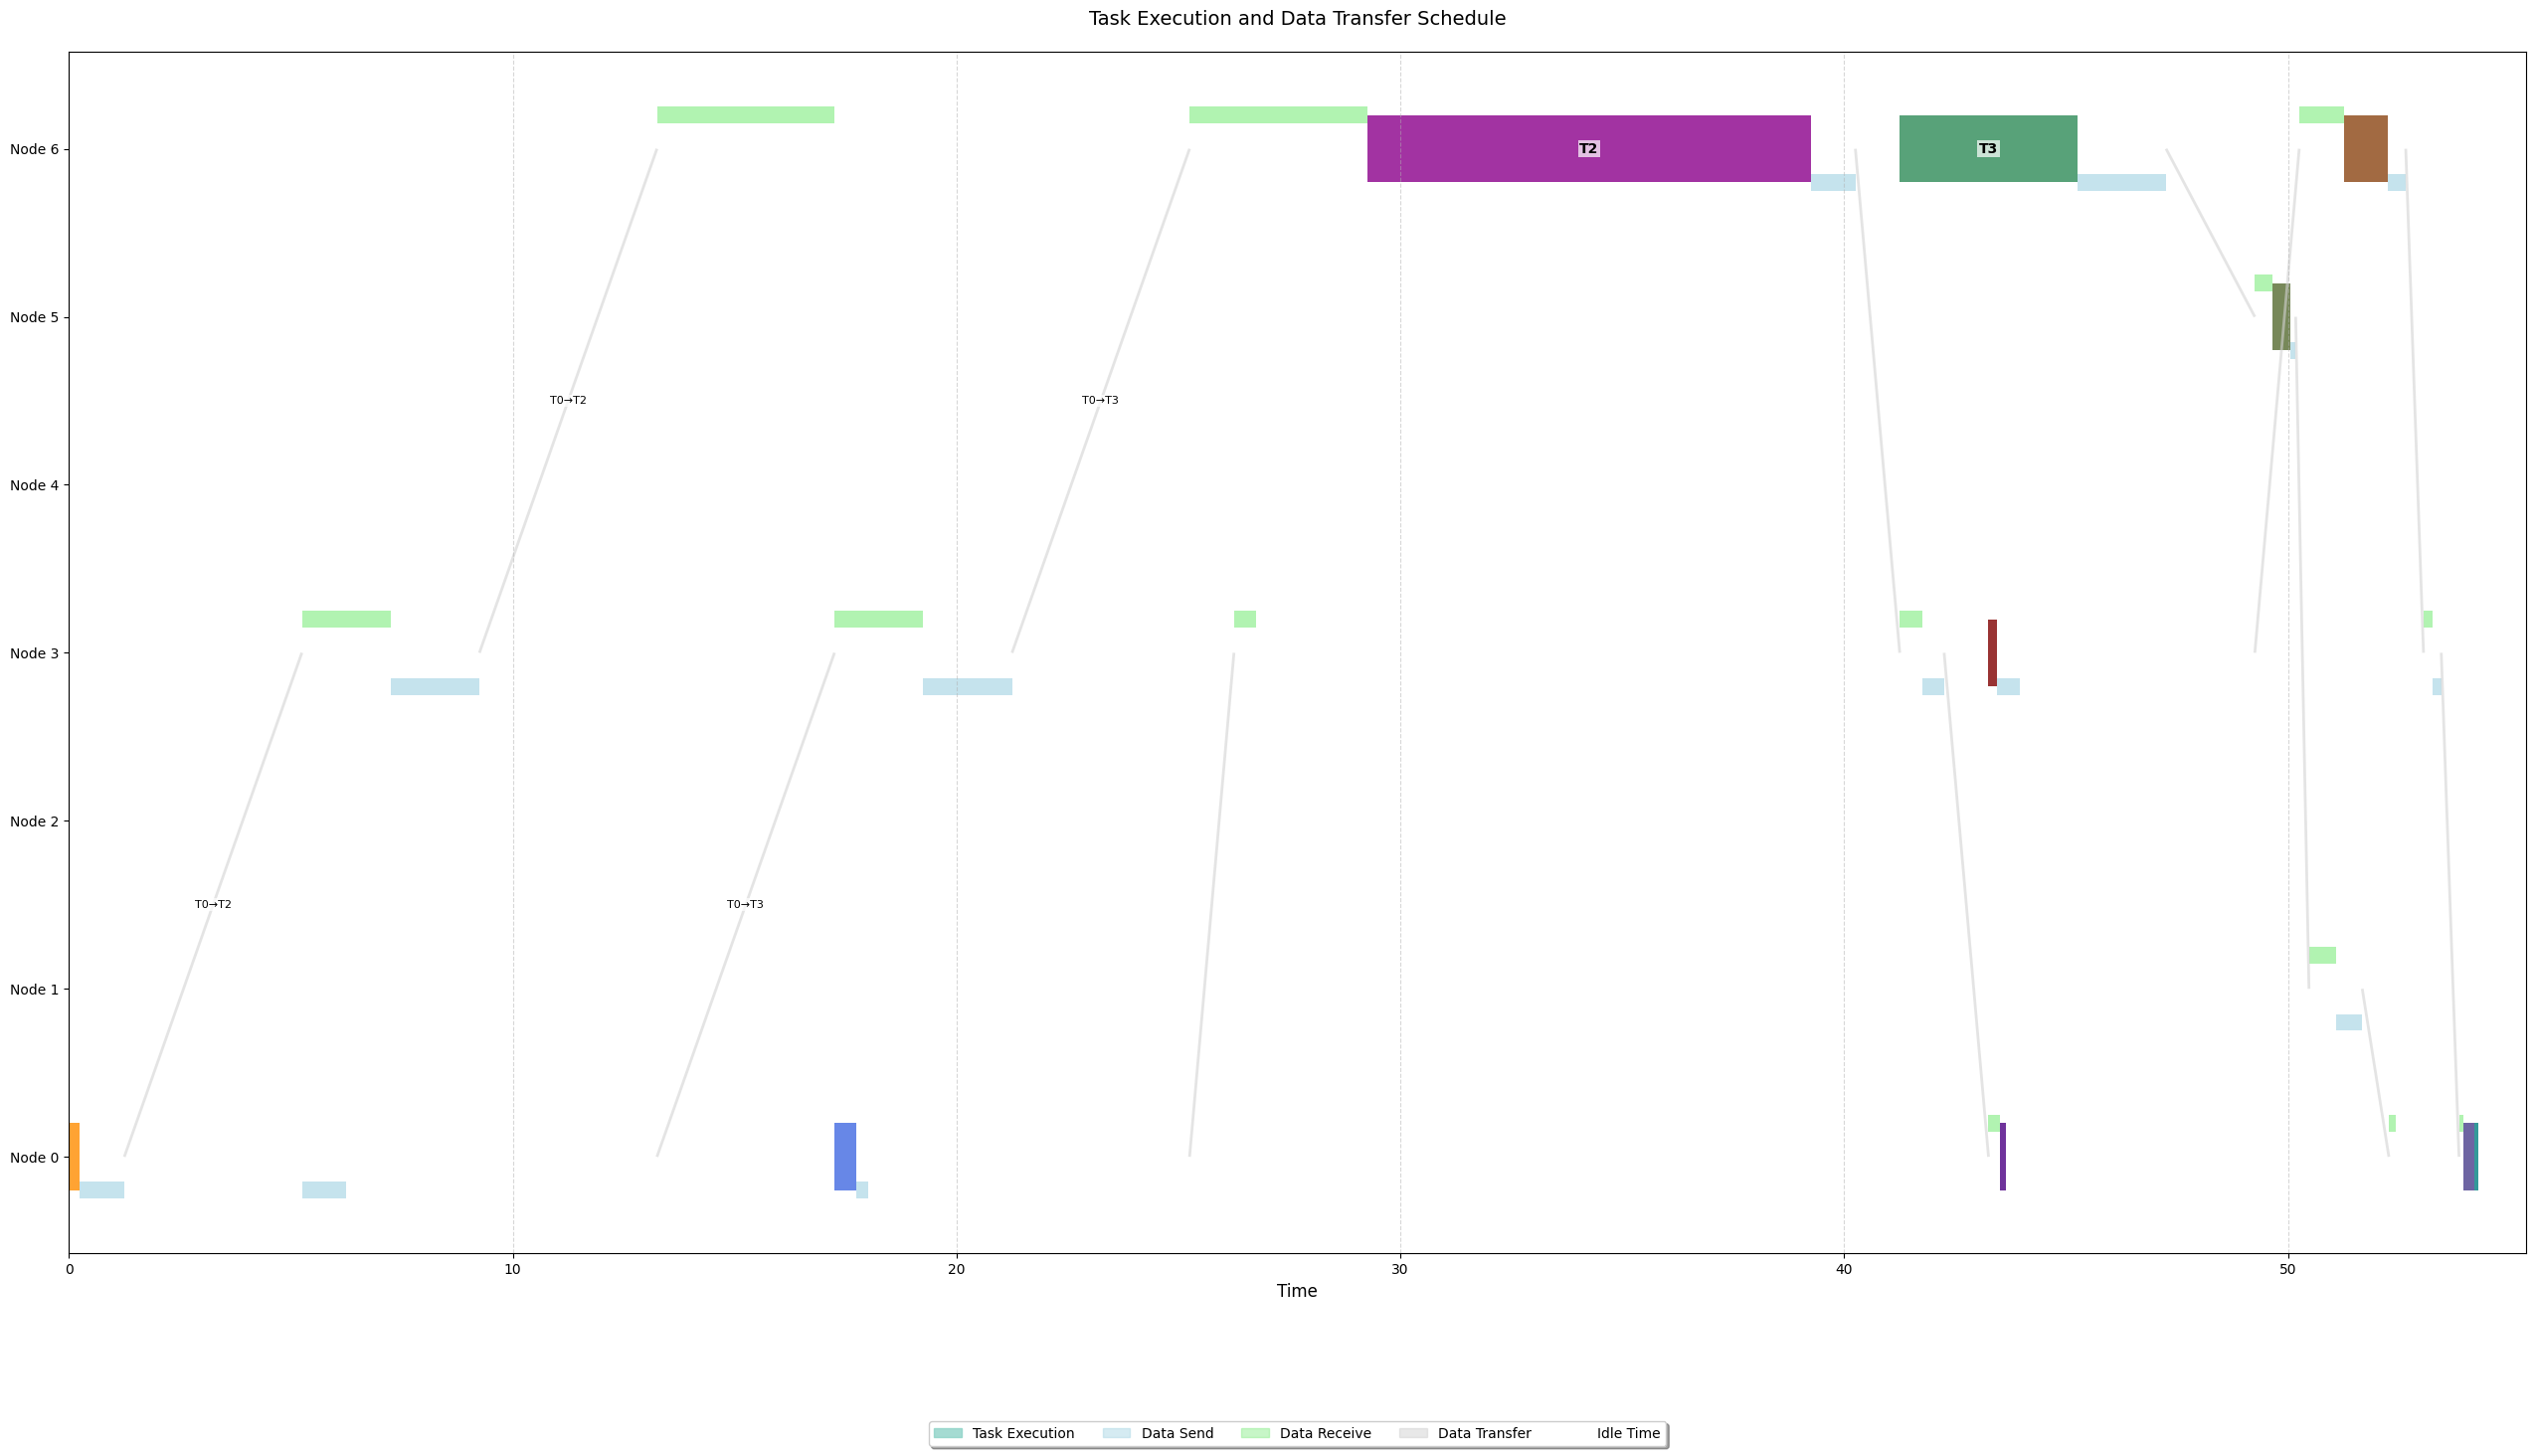

In [11]:
problem.net_status([0,0,6,6,3,0,5,6,0,0])
problem.scheduler.create_gantt_chart()


                  СОСТОЯНИЕ СЕТИ                  

               ХАРАКТЕРИСТИКИ УЗЛОВ               
Узел 0:
├─ Вычислительная мощность: 2000.0000
├─ Время работы: 6.8750
├─ Время отправки данных: 1.5000
└─ Время приема данных: 0.5500
Узел 1:
├─ Вычислительная мощность: 500.0000
├─ Время работы: 0.0000
├─ Время отправки данных: 0.0000
└─ Время приема данных: 0.0000
Узел 2:
├─ Вычислительная мощность: 1500.0000
├─ Время работы: 0.0000
├─ Время отправки данных: 0.0000
└─ Время приема данных: 0.0000
Узел 3:
├─ Вычислительная мощность: 1000.0000
├─ Время работы: 8.2000
├─ Время отправки данных: 4.1000
└─ Время приема данных: 4.1000
Узел 4:
├─ Вычислительная мощность: 500.0000
├─ Время работы: 0.0000
├─ Время отправки данных: 0.0000
└─ Время приема данных: 0.0000
Узел 5:
├─ Вычислительная мощность: 2500.0000
├─ Время работы: 0.0000
├─ Время отправки данных: 0.0000
└─ Время приема данных: 0.0000
Узел 6:
├─ Вычислительная мощность: 500.0000
├─ Время работы: 11.2000
├─ Время отправки данных

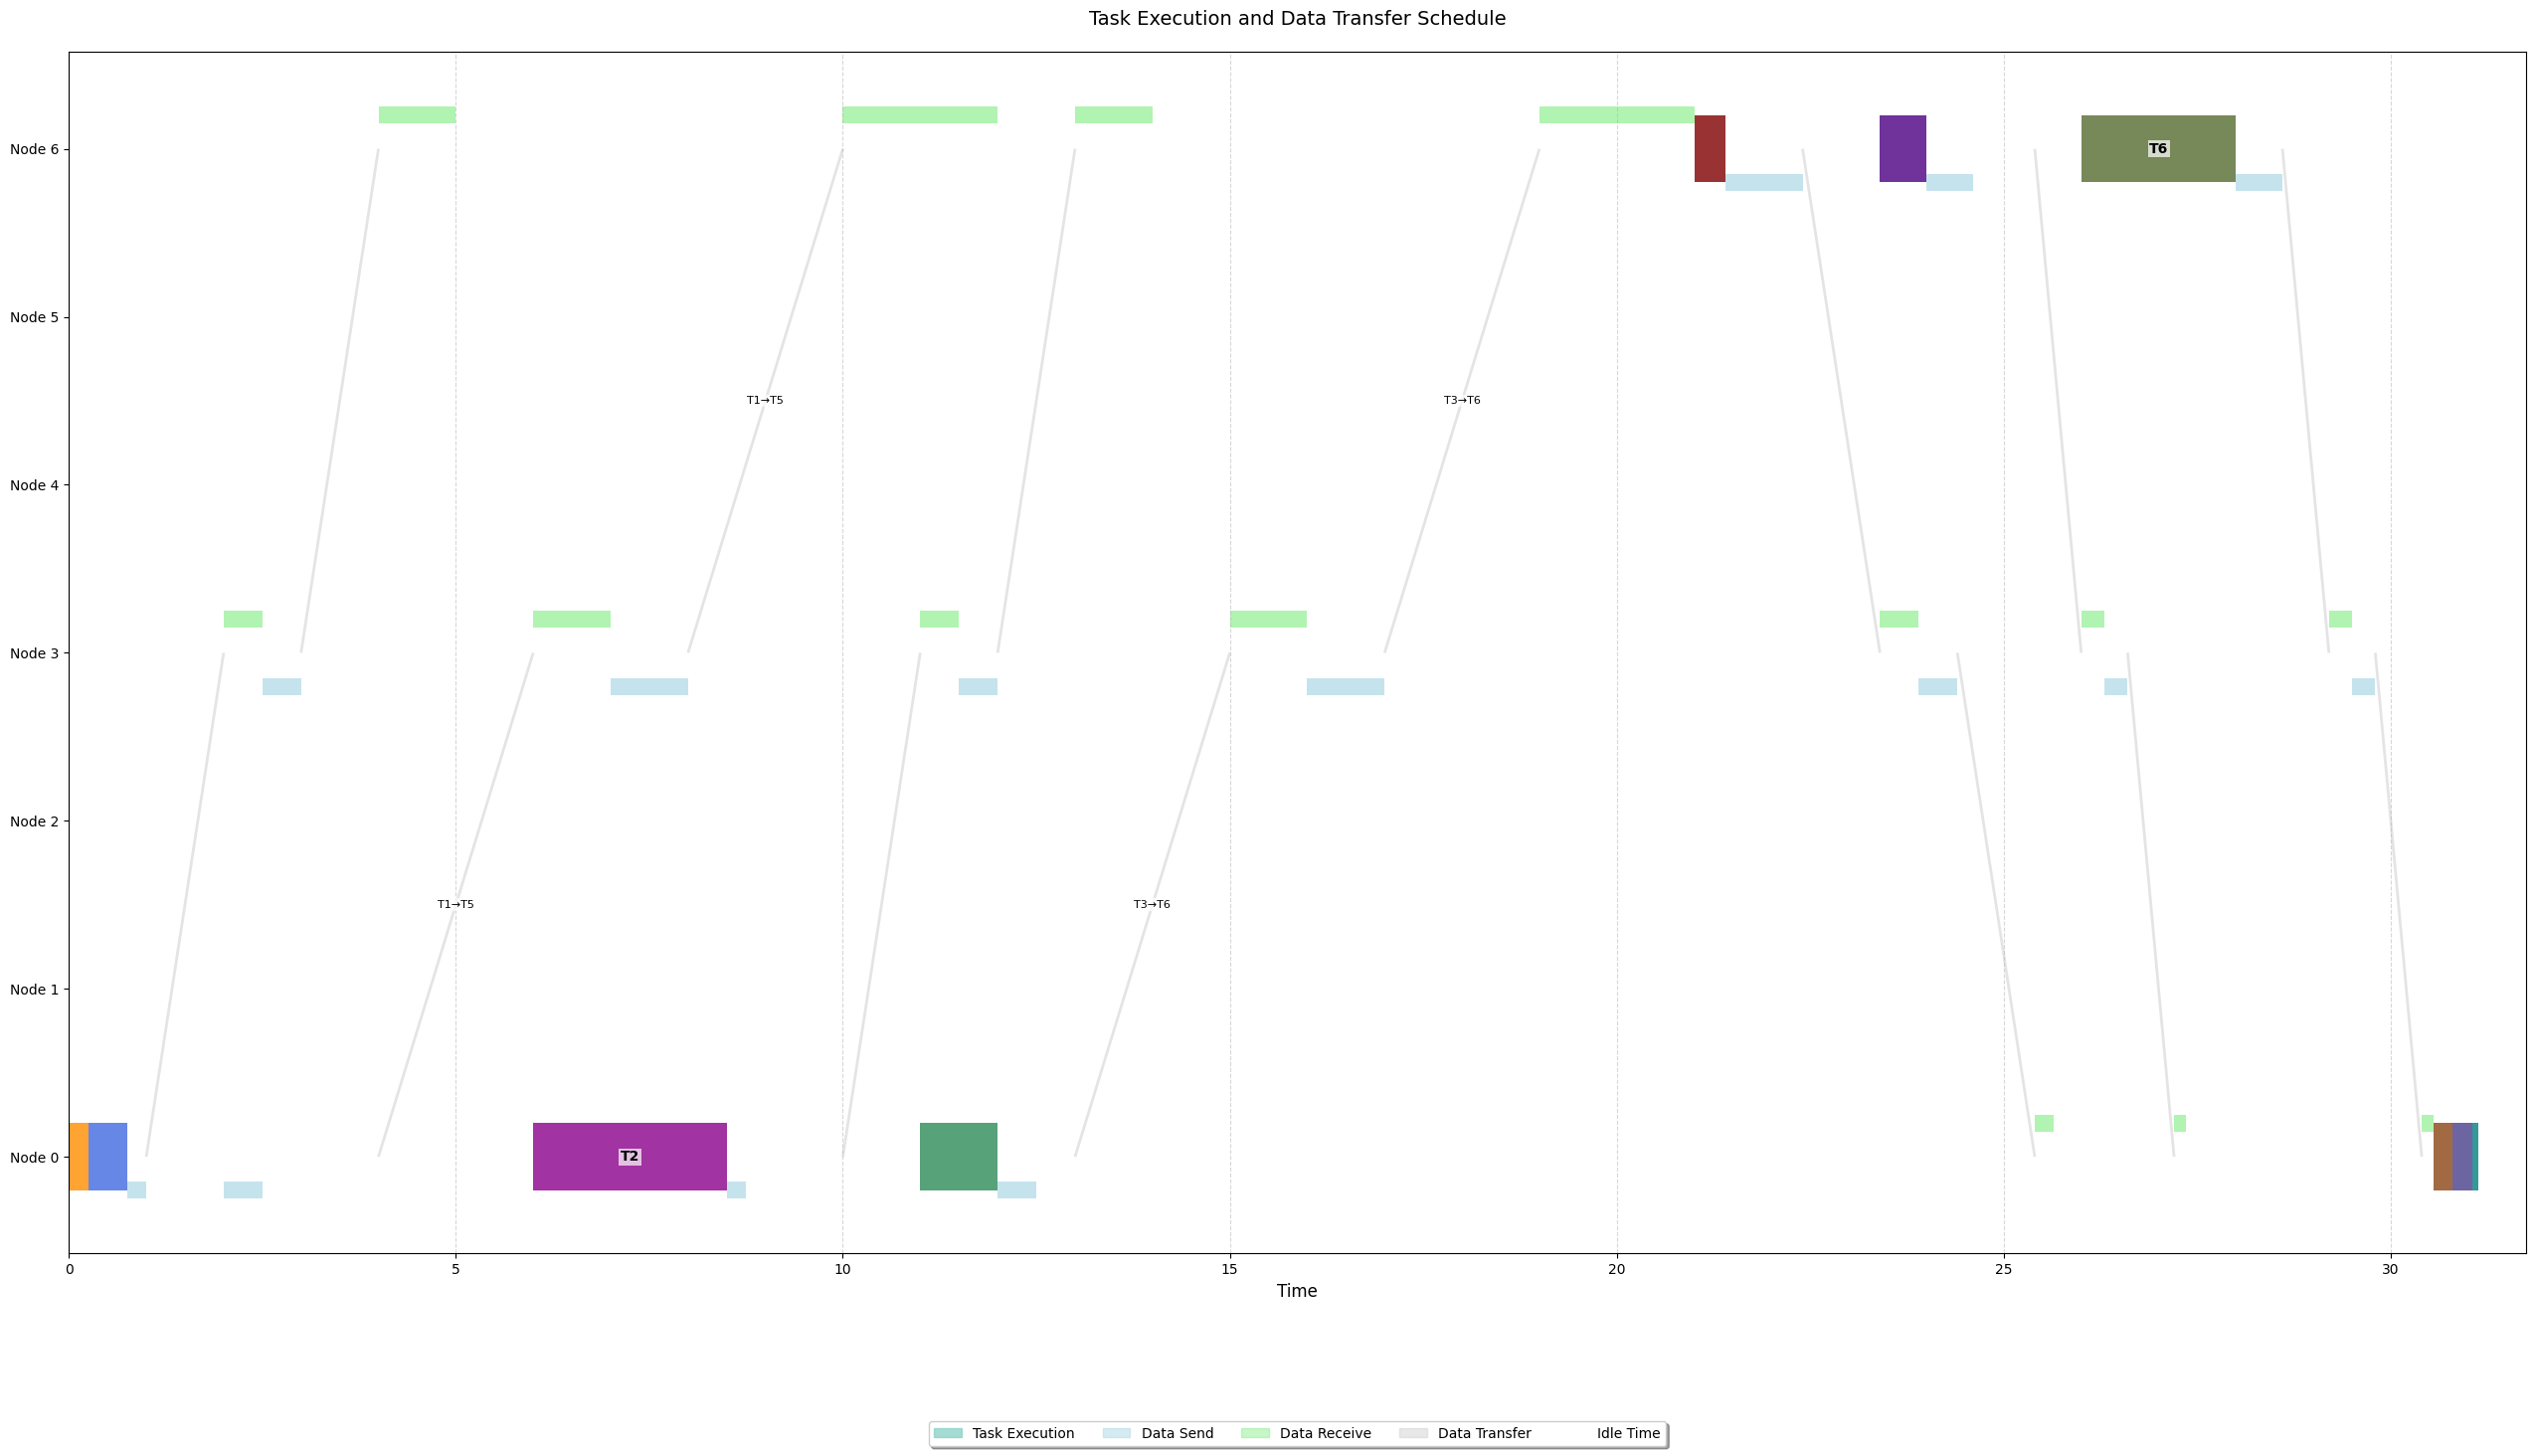

In [12]:
problem.net_status([0,0,0,0,6,6,6,0,0,0])
problem.scheduler.create_gantt_chart()

In [ ]:
from IPython.display import clear_output

for exp in range(0, 1):
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import ParticleSwarmOptimizer
    
    # Инициализация оптимизатора
    optimizer = ParticleSwarmOptimizer(problem, inertia = 1.7,cognitive = 2.5 , social = 1.5, num_particles=100, iterations=1000, update_history_coef = 100)
    print(len(optimizer.history))
    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)
    
    clear_output(wait=True)

Эксперемент 0
0


Optimizing:   8%|▊         | 76/1000 [00:01<00:19, 48.51it/s]c:\Users\user\Documents\MATH\optiLib\optimizers.py:113: RuntimeWarning: invalid value encountered in cast
  self.position += self.velocity.astype(self.problem.dtype)
Optimizing: 100%|██████████| 1000/1000 [00:07<00:00, 126.53it/s]


Лучшее решение: [0 0 3 0 0 0 0 0 0 0]
Значение целевой функции: 2
Данные сохранены в файл: ./data/NETproblem_1PSO.xlsx


In [14]:
/0

<>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
C:\Users\user\AppData\Local\Temp\ipykernel_15668\1350904145.py:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  0()


TypeError: 'int' object is not callable

In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer

    # Инициализация оптимизатора
    optimizer = RandomSearchOptimizer(problem, iterations=10000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)


Эксперемент 152


Optimizing:   0%|          | 10/10000 [00:00<00:07, 1332.67it/s]
c:\Users\user\Documents\MATH\optiLib\optimizers.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([existing_df, new_df], ignore_index=True)


Лучшее решение: [0 2 2 2 2 2 2 2 2 2]
Значение целевой функции: 3


KeyboardInterrupt: 

In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import DirectedRandomSearchOptimizer

    # Инициализация оптимизатора
    optimizer = DirectedRandomSearchOptimizer(problem, iterations=10000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)

In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import GeneticAlgorithm

    # Инициализация оптимизатора
    optimizer = GeneticAlgorithm(problem, population_size=100, generations=1000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)

In [ ]:
from optiLib import NetworkOptimizationProblem

problem = NetworkOptimizationProblem(net, task, f_objective=[f1_min_hop, f_min_workload_node_0, f_min_workload_node_1, f_min_workload_node_2, f_min_workload_node_3, f_min_workload_node_4, f_min_workload_node_5, f_min_workload_node_6, f_min_workload_node_7, f_min_workload_node_8], f_constraints=[c1_time_limit, c2_restriction_first_node], t_lim=5, net_speed=5000, bounds={0: [0,0]}, name="NETproblem_1")

In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer, ParticleSwarmOptimizer

    # Инициализация оптимизатора
    optimizer = ParticleSwarmOptimizer(problem, inertia = 1.7,cognitive = 2.5 , social = 1.5, num_particles=100, iterations=1000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    print(len(optimizer.history))
    if len(optimizer.history)>0:
        optimizer.save(exp)
    
    clear_output(wait=True)

In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer

    # Инициализация оптимизатора
    optimizer = RandomSearchOptimizer(problem, iterations=10000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)


In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import DirectedRandomSearchOptimizer

    # Инициализация оптимизатора
    optimizer = DirectedRandomSearchOptimizer(problem, iterations=10000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)

In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import GeneticAlgorithm

    # Инициализация оптимизатора
    optimizer = GeneticAlgorithm(problem, population_size=100, generations=1000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)

In [ ]:
1/0

In [ ]:
print(optimizer.history)

In [ ]:
problem.scheduler.calculate_schedule([0, 0, 4, 0, 3, 8, 4, 8, 8, 8, 8, 2, 8])

In [ ]:
problem.scheduler.print_extended_info()

In [ ]:
problem.scheduler.create_gantt_chart()

In [ ]:
problem.evaluate([0,2,2,2,1,1,0,0,0,0,0,0,0])

In [ ]:
status(tuple([0,8,5,2,1,1,0,0,7,0,0,0,8]), problem)

In [ ]:
RANDOM_SEED = 1
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

from optiLib.optimizers import RandomSearchOptimizer

# Инициализация оптимизатора
optimizer = RandomSearchOptimizer(problem,iterations = 1000)

# Запуск оптимизации
best_solution, best_value = optimizer.optimize()

from optiLib.helpers import print_solution
print_solution(best_solution, best_value)

for i, item in enumerate(optimizer.history):
    optimizer.history[i]={**item, **network_status_calculation(tuple(item['vector']), problem)}

optimizer.save()

In [ ]:
RANDOM_SEED = 1
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

from optiLib.optimizers import GreedyOptimizer

# Инициализация оптимизатора
optimizer = GreedyOptimizer(problem)

# Запуск оптимизации
best_solution, best_value = optimizer.optimize()

from optiLib.helpers import print_solution
print_solution(best_solution, best_value)

for i, item in enumerate(optimizer.history):
    optimizer.history[i]={**item, **network_status_calculation(tuple(item['vector']), problem)}

optimizer.save()